In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import string
import gensim
import operator
import re


In [2]:

df_movies = pd.read_json('meta.json', lines=True)
df_movies.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [4]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_sci_scibert')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens

In [6]:
df_movies_short = df_movies.head(1000)


In [8]:
print ('Cleaning and Tokenizing...')
%time df_movies_short['abstract'] = df_movies_short['abstract'].map(lambda x: spacy_tokenizer(x))

df_movies_short.head()

Cleaning and Tokenizing...
CPU times: user 8min 52s, sys: 20.8 s, total: 9min 13s
Wall time: 8min 44s
<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,"[fully, differential, calculation, perturbativ...","[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"[describe, new, algorithm, ell, pebble, game, ...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,"[evolution, earth, moon, system, describe, dar...","[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,"[determinant, stirle, cycle, number, count, un...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,"[paper, compute, lambda, alpha, norm, alpha, u...","[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [15]:
movie_plot = df_movies_short['abstract']
movie_plot[0:5]

0    [fully, differential, calculation, perturbativ...
1    [describe, new, algorithm, ell, pebble, game, ...
2    [evolution, earth, moon, system, describe, dar...
3    [determinant, stirle, cycle, number, count, un...
4    [paper, compute, lambda, alpha, norm, alpha, u...
Name: abstract, dtype: object

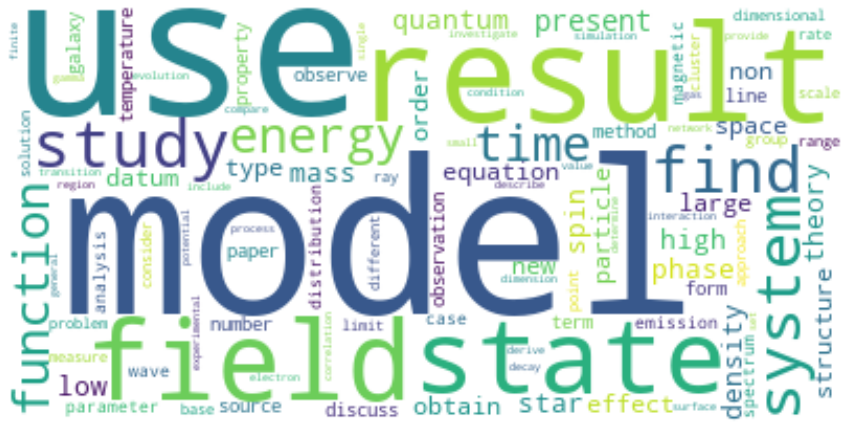

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(movie_plot)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(movie_plot)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

CPU times: user 92.3 ms, sys: 151 ms, total: 243 ms
Wall time: 282 ms


In [19]:
#print top 50 items from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['accuracy', 0], ['agreement', 1], ['anti', 2], ['antiquark', 3], ['boson', 4], ['calculation', 5], ['cdf', 6], ['chromodynamic', 7], ['collider', 8], ['contrast', 9], ['contribution', 10], ['data', 11], ['datum', 12], ['decay', 13], ['demonstrate', 14], ['detailed', 15], ['differential', 16], ['diphoton', 17], ['distribution', 18], ['energy', 19], ['enhance', 20], ['event', 21], ['fermilab', 22], ['fully', 23], ['gluon', 24], ['good', 25], ['hadron', 26], ['higgs', 27], ['include', 28], ['initial', 29], ['judicious', 30], ['large', 31], ['lead', 32], ['leading', 33], ['lhc', 34], ['logarithmic', 35], ['massive', 36], ['obtain', 37], ['order', 38], ['pair', 39], ['perturbative', 40], ['phase', 41], ['photon', 42], ['prediction', 43], ['present', 44], ['process', 45], ['produce', 46], ['production', 47], ['qcd', 48], ['quantum', 49], ['quark', 50]]]


In [21]:
corpus = [dictionary.doc2bow(desc) for desc in movie_plot]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('accuracy', 1), ('agreement', 1), ('anti', 1), ('antiquark', 1), ('boson', 1), ('calculation', 2), ('cdf', 1), ('chromodynamic', 1), ('collider', 2), ('contrast', 1), ('contribution', 1), ('data', 1), ('datum', 1), ('decay', 1), ('demonstrate', 1), ('detailed', 1), ('differential', 1), ('diphoton', 2), ('distribution', 2), ('energy', 1), ('enhance', 1), ('event', 1), ('fermilab', 1), ('fully', 1), ('gluon', 4), ('good', 1), ('hadron', 2), ('higgs', 1), ('include', 1), ('initial', 1), ('judicious', 1), ('large', 1), ('lead', 1), ('leading', 1), ('lhc', 2), ('logarithmic', 1), ('massive', 1), ('obtain', 1), ('order', 2), ('pair', 3), ('perturbative', 2), ('phase', 1), ('photon', 1), ('prediction', 2), ('present', 1), ('process', 1), ('produce', 2), ('production', 1), ('qcd', 1), ('quantum', 1), ('quark', 2), ('radiation', 1), ('region', 1), ('reliable', 1), ('resummation', 1), ('selection', 1), ('sensitivity', 1), ('signal', 1), ('space', 1), ('specify', 1), ('state', 1), ('subprocess

In [22]:
%time movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
%time movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

CPU times: user 31.2 ms, sys: 2.57 ms, total: 33.8 ms
Wall time: 32.5 ms
CPU times: user 2.78 s, sys: 432 ms, total: 3.21 s
Wall time: 1.12 s


In [24]:
%time gensim.corpora.MmCorpus.serialize('meta_model/meta_tfidf_model_mm', movie_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('meta_model/meta_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

CPU times: user 371 ms, sys: 10.6 ms, total: 381 ms
Wall time: 383 ms
CPU times: user 1.12 s, sys: 31.3 ms, total: 1.15 s
Wall time: 1.16 s


In [25]:
#Load the indexed corpus
movie_tfidf_corpus = gensim.corpora.MmCorpus('meta_model/meta_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('meta_model/meta_lsi_model_mm')

print(movie_tfidf_corpus)
print(movie_lsi_corpus)

MmCorpus(1000 documents, 7352 features, 48370 non-zero entries)
MmCorpus(1000 documents, 300 features, 300000 non-zero entries)


In [26]:
from gensim.similarities import MatrixSimilarity

%time movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

CPU times: user 428 ms, sys: 9.91 ms, total: 438 ms
Wall time: 437 ms


In [41]:
from operator import itemgetter

def search_similar_movies(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]

    movie_index.num_best = 5

    movies_list = movie_index[query_lsi]

    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Article Title': df_movies_short['title'][movie[0]],
                'Article Plot': df_movies_short['abstract'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break
    return movies_list[0]
    return pd.DataFrame(movie_names, columns=['Relevance','Article Title','Article Plot'])

In [42]:
search_similar_movies('transistors')

567